----

# Artificial Intelligence - COMPSCI4004

## Lab Week 6: Sequential decision-making under uncertainty

<font color=red>SOLUTIONS</font>

---

**Purpose/Learning objectives:**
* Get hands-on experience with sequential decision-making in uncertain scenarios/environments
* Formulate and define MDPs for realistic problems (in Python)
* Solve MDPs using Value Iteration and find a policy using MEU to better understand what the Bellman equations are and what they can be used for.


**Guide:** The notebook contains specific tasks you'll need to carry out to make the notebook run. These are indicated with::

* <font color=dark-magenta>TASK:</font> This is a task for you to carry out before proceeding
* <font color=green>CHECKPOINT:</font> This indicates a key point you should understand before proceeding

It is important that you reach question Q6.4 and experiment with different transition models and reward functions. If you're in a hurry and already comfortable with MDPs, you can jump to Q6.2.

**Notice:** This notebook is comprehensive and will most likely take you 3-4h to complete; this is expected (a solution will be provided a few days after the lab session).

----

### Q6.0 Introduction & Housekeeping 

In this exercise, we explore how to make decisions in uncertain domains using techniques from probability and utility theory, with a particular focus on sequential decisions using Markov Decision Processes (MDPs).

#### Q6.0.1 Prerequisites

You will need to import a few basic models from the `AIMA toolbox`. Importing the modules should happen without error. If you get an error you probably need to update your Python installation with the modules causing the issue.

NOTE: If you get an error due to ipywidgets, then either try to install/update the module or comment them out and do the exercise without the visualization part.

In [1]:
import sys
print(sys.version)

3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]


In [2]:
AIMA_TOOLBOX_ROOT="C:/Users/Edmond Ho/OneDrive - University of Glasgow/Course/AI/2024-25/aima-python-uofg_v20212022a"
sys.path.append(AIMA_TOOLBOX_ROOT)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import random

import ipywidgets as widgets
from IPython.display import display

In [4]:
from aimautils import argmax, vector_add, print_table
from grid import orientations, turn_right, turn_left # note grid.py is provided in the zip file of the lab materials

----

#### Q6.0.2 Sequential Decisions - Markov decision processes (MDPs)

#### The Basics

- The real world is uncertain but we as humans still manage to make decisions every day. Probability and utility theory can help us design artificial systems which can cope with certain types of uncertainty, i.e. MDPs help us deal with fully observable and non-deterministic/stochastic environments. For dealing with partially observable and stochastic cases we make use of the generalization of MDPs named POMDPs (partially observable Markov decision process) which we will not consider in this session.

- A stochastic process has the **Markov property** if the conditional probability distribution of future states of the process (conditional on both past and present states) depends only upon the present state, not on the sequence of events that preceded it. In our case it is the transitions model which has this property, i.e. the next depends only on the previous one, not the full history e.g. $P(s_{3}|s_2,a)$ and not $P(s_{3}|s_2,s_1,s_0,a)$

- The overall reason for solving an MDP is to come up with a policy that guides us in selecting the best action in each state so we maximize the expected sum of future rewards given that the transition model represents uncertainty in the environment.

----

### Q6.1 Basics: Implementing and representing an MDP

***Note:*** you can skip this part if you are already comfortable with MDPs (goto Q6.2-Q.7.4).

##### Q6.1.1 Representing an MDP in Python 

* <font color=dark-magenta>TASK:</font> Inspect the following code which implements a class for representing an MDP in Python. This is still a rather empty class but you should see that the class can represent all the mathematical objects we need to define an MDP. <br>

In [5]:
class MDP:

    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text.  Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs.  We also keep track of the possible states,
    terminal states, and actions for each state. [page 646]"""

    def __init__(self, init, actlist, terminals, gamma=.9):
        self.init = init
        self.actlist = actlist
        self.terminals = terminals
        if not (0 <= gamma < 1):
            raise ValueError("An MDP must have 0 <= gamma < 1")
        self.gamma = gamma
        self.states = set()
        self.reward = {}

    def R(self, state):
        "Return a numeric reward for this state."
        return self.reward[state]

    def T(self, state, action):
        """Transition model.  From a state and an action, return a list
        of (probability, result-state) pairs."""
        raise NotImplementedError

    def actions(self, state):
        """Set of actions that can be performed in this state.  By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

- The **_ _init_ _** method takes in the following parameters:

    - init: the initial state.
    - actlist: List of actions possible in each state.
    - terminals: List of terminal states where the only possible action is exit
    - gamma: Discounting factor. This makes sure that delayed rewards have less value compared to immediate ones.

- **R** method returns the reward for each state by using the self.reward dict.

- **T** method is not implemented and is somewhat different from the text. Here we return (probability, s') pairs where s' belongs to the list of possible states by taking action a in state s.

- **actions** method returns the list of actions possible in each state. By default, it returns all actions for states other than terminal states.


----

##### Q6.1.2 A Simple MDP

In order to get experience with reading an MDP from a state-space representation with decision nodes, we'll consider the following state-space / action graph: 
<img src="./resources/mdp-b.png">

<font color=dark-magenta>TASK:</font>  From the figure above;
* Identify and list the states
* Identify and list the actions possible in each state, i.e., A(s)
* Identify and list the rewards, i.e. R(s)
* Determine the transition model, i.e. write down (on paper or in the notebook) a list or table with the relevant probabilities.

<div style="border:2px solid red">
<font color="red">SOLUTION</font>

States: A,B,C (note: the notation is not ideal here usign capital letters to denote the outcome of a random variable S but you will see this from time to time)

Actions: 
- $Actions(S=A)=\{X,Y\}$
- $Actions(S=B)=\{X,Y\}$
- $Actions(S=End)=$Ø (it is a terminal state)

Rewards:
- $R(S=A)$ = 5
- $R(S=B)$ = -10
- $R(S=C)$ = 100

Transition model - we don't need to worry about what happends in "End" as the process stops here:

- $P(S_{t+1}=A|S_t=A, Action=X)=0.3$

- $P(S_{t+1}=B|S_t=A, Action=X)=0.7$

- $P(S_{t+1}=A|S_t=A, Action=Y)=1.0$

- $P(S_{t+1}=B|S_t=A, Action=Y)=0.0$

<br>

- $P(S_{t+1}=B | S_t=B, Action=X)=0.2$

- $P(S_{t+1}=End  |S_t=B, Action=X)=0.8$

- $P(S_{t+1}=A | S_t=B, Action=Y)=1.0$


</div>

----

##### Q6.1.3 Representing the elements of an MDP

In the following we show you how to represent the elements of an MDP in Python (using the AIMA toolbox).
- <font color=dark-magenta>TASK:</font> You'll now need to fill in the missing elements yourself with the values you have identified in Q6.1.2 (look for "TODO")

In [6]:
# Transition Matrix as nested dict. 
# State -> Actions in state -> States by each action -> Probabilty

t = {
    "A": {
            "X": {"A":0.3, "B":0.7},
            "Y": {"A":1.0}            
         },
    "B": {
            "X": TODO,            
            "Y": {"A":1.0}
         },
    "End": {}
}

init = "A" # initial state

terminals = ["End"]

rewards = {
    "A": 5,
    "B": TODO,
    "End": TODO  
}

NameError: name 'TODO' is not defined

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

In [7]:
# Transition Matrix as nested dict. 
# State -> Actions in state -> States by each action -> Probabilty

t = {
    "A": {
            "X": {"A":0.3, "B":0.7},
            "Y": {"A":1.0}            
         },
    "B": {
            "X": {"End":0.8, "B":0.2},            
            "Y": {"A":1.0}
         },
    "End": {}
}

init = "A"

terminals = ["End"]

rewards = {
    "A": 5,
    "B": -10,
    "End": 100   
}

<div style="border:2px solid red"></div>

---

##### Q6.1.4 Creting the MDP module
In order to define an MDP with the actual transition model defined above we will now create a custom class CustomMDP from Q6.1.1 (which calls the generic MDP class) internally and implement the required transition model:

In [8]:
class CustomMDP(MDP):

    def __init__(self, transition_matrix, rewards, terminals, init, gamma=.9):
        # All possible actions.
        actlist = []
        for state in transition_matrix.keys():
            actlist.extend(transition_matrix.keys())
        actlist = list(set(actlist))

        MDP.__init__(self, init, actlist, terminals=terminals, gamma=gamma)
        self.t = transition_matrix
        self.reward = rewards
        for state in self.t:
            self.states.add(state)

    def T(self, state, action):
        return [(new_state, prob) for new_state, prob in self.t[state][action].items()]

Finally we instantiate the class with the parameters for our MDP in the picture.

In [9]:
our_mdp = CustomMDP(t, rewards, terminals, init, gamma=.9)

We can now probe the MDP in various ways including getting lists of the actions - or more interestingsly evaluate $P(S_{t+1}|S_{t}=A,Action=X)$ as follows

In [10]:
our_mdp.T('A','X')

[('A', 0.3), ('B', 0.7)]

<br>
<font color=dark-magenta>TASK:</font> Does the outcome of `our_mdp.T('A','X')` match your expectation from the graph ?

<div style="border:2px solid red">
<font color="red">SOLUTION</font>

`our_mdp.T('A','X')` should lead to: [('A', 0.3), ('B', 0.7)]

<br>

</div>

<font color=green>CHECKPOINT:</font> With this you should now know how to define and represent an MDP in Python..

---

### Q6.2 Grid MDP

In Q6.2-Q6.5 we'll look at a concrete implementation that makes use of the `MDP` from Q6.1 as a base class (similarly to the CustomMDP) to do some actual planning.

We'll consider a grid world similar to **Fig 17.1** in the AIMA book (x,y are zero-indexed not one-indexed as in the book)


<img src="./resources/maze_0c.png" width="500px">

<font color=green>CHECKPOINT:</font> Pay attention to the notation here !
- $P_a$ refers to the case where the actual action taken is the intended action
- $P_l$ refers to the case where the actual action taken is -90 degrees off the intended action, i.e. to the "left" of the intended action (not to the left in absolute terms except for when the intended action is up/north). 
- $P_r$ refers to the case where the actual action taken is +90 degrees off the intended action, i.e. to the "right" of the intended action (not literally to the right except for when the intended action is up/north)

- For example; if the intended action is down (south) this is taken/achieved with probability $P_a$, but with probability $P_r$ the action is actually west i.e. "right" of the intended action. 

----

##### Q6.2.0 Why is this an interesting problem...?

<br>

- <font color=dark-magenta>TASK:</font> Give at least two "real-world" examples/scenarios where there is uncertainty related to the outcome of an action in a navigation scenario as the Grid world. Discuss with your fellow students or tutors to make sure you appreciate that this is not an uncommon scenario.


<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>
    
There are many examples, e.g.: 
- Travel planning: When planning a multi-leg plane trip from Glasgow to Madrid (e.g. for a wedding); there are several uncertanties related to the outcome of each leg (e.g. delayes, detours and cancelleation). We normally account for these uncertanties without explicity thinking about it and trade off the risk of not geting to the wedding (i.e. not receiving the reward) and getting there (e.g. leaving early and choosing reliable airlines) \\

- The paper: http://www.cs.uml.edu/ecg/uploads/AIfall14/MDPApplications3.pdf , provides a long list of applications where MDPs have been used to model a real-world problem.

<div style="border:2px solid red"></div>

----

##### Q6.2.1 Analysis of the GridMDP class

The GridMDP class below is used to represent a grid world MDP like the one shown in **Fig 17.1** of the AIMA Book (with a few minor changes!).

In [11]:
class GridMDP(MDP):

    """A two-dimensional grid MDP, as in [Figure 17.1].  All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state).  Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        MDP.__init__(self, init, actlist=orientations,
                     terminals=terminals, gamma=gamma)
        self.grid = grid
        self.rows = len(grid)
        self.cols = len(grid[0])
        for x in range(self.cols):
            for y in range(self.rows):
                self.reward[x, y] = grid[y][x]
                if grid[y][x] is not None:
                    self.states.add((x, y))

    def T(self, state, action):
        Pa = 0.7
        Pl = 0.1
        Pr = 0.2 
        
        if action is None:
            return [(0.0, state)]
        else:
            return [(Pa, self.go(state, action)),
                    (Pr, self.go(state, turn_right(action))),
                    (Pl, self.go(state, turn_left(action)))]

    def go(self, state, direction):
        "Return the state that results from going in this direction."
        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""
        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {
            (1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})

- The **_ _init_ _** method takes **grid** as an extra parameter compared to the MDP class. The grid is a nested list of rewards in states.
- **go** method returns the state by going in a particular direction by using vector_add.
- **T** method is not implemented and is somewhat different from the text. Here we return (probability, s') pairs where s' belongs to a list of possible states by taking action a in state s.
- **actions** method returns a list of actions possible in each state. By default, it returns all actions for states other than terminal states.
- **to_arrows** are used for representing the policy in a grid-like format.

* <font color=dark-magenta>TASK:</font> From inspecting the code for the GridMDP, determine the transition model (i.e. the uncertainty associated with the outcome of the actions). Write down the transition model as a table/list (you should exploit the Markov property implied by the problem definition). 
<br>

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>
    
The transition model is the same for all states

If not runing into walls:
- $P( \text{Outcome-Is-North} | s, Action=Up/North) = P_a = 0.7$
- $P( \text{Outcome-Is-West}  | s, Action=Up/North) = P_l = 0.1$
- $P( \text{Outcome-Is-East}  | s, Action=Up/North) = P_r = 0.2$

<br>

- $P( \text{Outcome-Is-South} | s, Action=Down/South) = P_a = 0.7$
- $P( \text{Outcome-Is-East}  | s, Action=Down/South) = P_l = 0.1$
- $P( \text{Outcome-Is-West}  | s, Action=Down/South) = P_r = 0.2$

<br>

- $P( \text{Outcome-Is-West}  | s, Action=Left/West) = P_a = 0.7$
- $P( \text{Outcome-Is-South} | s, Action=Left/West) = P_l = 0.1$
- $P( \text{Outcome-Is-North} | s, Action=Left/West) = P_r = 0.2$

<br>

- $P( \text{Outcome-Is-East}  | s, Action=Right/South) = P_a = 0.7$
- $P( \text{Outcome-Is-North} | s, Action=Right/South) = P_l = 0.1$
- $P( \text{Outcome-Is-South} | s, Action=Right/South) = P_r = 0.2$

BUT if an action results in the agent hitting a wall then the agent stays in s with:

$$P(\text{Outcome-Is-Stay-In-s} \,|\, s, \text{Action=Action-Leading-To-Hitting-Wall})$$

e.g. if taking action Up/North in (0,0) there is 0.1 probability of ending up in (0,0) again.

<br>

<div style="border:2px solid red"></div>

* <font color=dark-magenta>TASK:</font> The model is different from the transition model in the lecture/AIMA (Ch 17) - but how ? This could potentially change the policy but it is difficult to know exactaly before solving the Bellman equations... 

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

- The transition model has different probabilities, allthough the overall principle is the same.

<div style="border:2px solid red"></div>

----

##### Q6.2.2 Create an instance of the GridMDP class

We can create a GridMDP like the one in **Fig 17.1** as follows:

In [12]:
Rstep = -0.04  # the reward for being in a non-terminal state
Rt    = 1      # defines the reward for ending in a terminal state
gamma = 0.9    # discounting factor

grid_world_4x3 = GridMDP([[Rstep, Rstep, Rstep, Rt],
                          [Rstep, None,  Rstep, -Rt],
                          [Rstep, Rstep, Rstep, Rstep]],
                          terminals=[(3, 2), (3, 1)],
                          init=[(0, 0)],
                          gamma=gamma)


* <font color=dark-magenta>TASK:</font> Gamma defines the discount factor i.e. how much you favor immediate rewards over future (potentially uncertain) rewards. Try to change it to 1 - what do you see and is this expected (hint: it might be worth looking up the role of gamma in the book)? (p.s. change it back to 0.9 and rerun the cell before continuing)

<div style="border:2px solid red">
<font color="red">SOLUTION</font>

- $\gamma$ indicates preference for immediate rewards over future (potentially) less certain rewards and should be between [0,1], however most nummerical algorithms requres gamma to be ]0,1[ for them to converge.

</div>

----

### Q6.3 Solving the GridMDP

Recall that the actual goal is to obtain an optimal policy $\pi$ i.e. find a function that maps from a state to a recommended action for all states which on average gives us the highest sum of discounted rewards. 

We'll do this in two steps:

* 1) Assign utility (or value) to all states (Q6.3.0-Q6.3.3)
    * The utility (or value) of each state is the expected sum of discounted future rewards.

* 2) Using the maximum expected utility principle to select the best policy (Q6.3.4)


----

#### Q6.3.0 Bellman equations

The Bellman (optimallity) equations relates the optimal utility of a state to the optimal utility of its neighboring states.

- <font color=dark-magenta>TASK:</font> Inspect the lecture notes / book and write down the Bellman equations: a) in general and b) for state (0,0) and (1,0) in this particular problem.

<div style="border:2px solid red">
<font color="red">SOLUTION</font>

$${U }\left( s \right) = R\left( s \right) + \gamma \text{max}_a \sum\limits_{s'}^{} {p\left( {s'|s,a } \right)U\left( {s'} \right)} $$

See also the lecture notes for U(0,0); make sure to account for all possible outcomes in each state before taking the max

We will structure the elements inside the max operation as:

$$\begin{gathered}
  {P_{\text{a}}} \times U({\text{s' if}}\,{\text{the actual outcome is the intended action a}}) + {P_{\text{l}}} \times U({\text{s' if}}\,{\text{the actual outcome is -90 degrees, i.e. to the "left" of the intended action}}) + {P_{\text{r}}} \times U({\text{s' if}}\,{\text{the actual outcome is +90 degrees, i.e. to the "right" of the intended action}}) \hfill \\
   \hfill \\ 
\end{gathered}$$


For state (0,0) (note: we use curly brackets just for convenience):
$$\begin{gathered}
  s = \{ 0,0\}  \hfill \\
  U(s) = R(s) + \gamma  \times {\max _a}\{  \hfill \\
  P(\{ 0,1\} |up,s)U(\{ 0,1\} ) + P(\{ 0,0\} |up,s)U(\{ 0,0\} ) + P(\{ 1,0\} |up,s)U(\{ 1,0\} ),\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,(up) \hfill \\
  P(\{ 0,0\} |down,s)U(\{ 0,0\} ) + P(\{ 1,0\} |down,s)U(\{ 1,0\} ) + P(\{ 0,0\} |down,s)U(\{ 0,0\} ),\,\,\,\,\,\,\,\,\,(down) \hfill \\
  P(\{ 0,0\} |left,s)U(\{ 0,0\} ) + P(\{ 0,0\} |left,s)U(\{ 0,0\} ) + P(\{ 0,1\} |left,s)U(\{ 0,1\} ),\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,(left) \hfill \\
  P(\{ 1,0\} |right,s)U(\{ 1,0\} ) + P(\{ 0,1\} |right,s)U(\{ 0,1\} ) + P(\{ 0,0\} |right,s)U(\{ 0,0\} ),\,\,\,\,\,\,\,\,\,\,\,\,\,(right) \hfill \\
  \}  \hfill \\
   = R(s) + \gamma  \times {\max _a}\{  \hfill \\
  {P_{\text{a}}} \times U(\{ 0,1\} ) + {P_{\text{l}}} \times U(\{ 0,0\} ) + {P_{\text{r}}} \times U(\{ 1,0\} ),\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,(up) \hfill \\
  {P_{\text{a}}} \times U(\{ 0,0\} ) + {P_{\text{l}}} \times U(\{ 1,0\} ) + {P_{\text{r}}} \times U(\{ 0,0\} ),\,\,\,\,\,\,\,\,\,\,\,(down) \hfill \\
  {P_{\text{a}}} \times U(\{ 0,0\} ) + {P_{\text{l}}} \times U(\{ 0,0\} ) + {P_{\text{r}}} \times U(\{ 0,1\} ),\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,(left) \hfill \\
  {P_{\text{a}}} \times U(\{ 1,0\} ) + {P_{\text{l}}} \times U(\{ 0,1\} ) + {P_{\text{r}}} \times U(\{ 0,0\} ),\,\,\,\,\,\,\,\,\,\,\,\,\,(right) \hfill \\
  \}  \hfill \\ 
\end{gathered},$$
where ${P_{\text{a}}} = 0.7,{P_{\text{l}}} = 0.1\,and\,{P_{\text{r}}} = 0.2$.

<br>

For state (1,0):
$$\begin{gathered}
  s = \{ 1,0\}  \hfill \\
  U(s) = R(s) + \gamma  \times {\max _a}\{  \hfill \\
  {P_{\text{a}}} \times U(\{ 1,0\} ) + {P_{\text{l}}} \times U(\{ 0,0\} ) + {P_{\text{r}}} \times U(\{ 2,0\} ),\,\,\,\,\,\,\,\,\,(up = north) \hfill \\
  {P_{\text{a}}} \times U(\{ 1,0\} ) + {P_{\text{l}}} \times U(\{ 2,0\} ) + {P_{\text{r}}} \times U(\{ 0,0\} ),\,\,\,\,\,\,\,\,\,(down = south) \hfill \\
  {P_{\text{a}}} \times U(\{ 0,0\} ) + {P_{\text{l}}} \times U(\{ 1,0\} ) + {P_{\text{r}}} \times U(\{ 1,0\} ),\,\,\,\,\,\,\,\,\,(left = west) \hfill \\
  {P_{\text{a}}} \times U(\{ 2,0\} ) + {P_{\text{l}}} \times U(\{ 1,0\} ) + {P_{\text{r}}} \times U(\{ 1,0\} ),\,\,\,\,\,\,\,\,\,\,(right = east) \hfill \\
  \}  \hfill \\ 
\end{gathered} $$


</div>

- <font color=dark-magenta>TASK:</font> Explain (to the tutors or formulate in writing) why it is difficult to solve the Bellman equations for U(s) ?

<div style="border:2px solid red">
<font color="red">SOLUTION</font>

- The Bellman (optimiallay) equations is a set of non-linear equations which requires nummerical solutions as no closed-form/analytical solutions exists.

</div>

<font color=green>CHECKPOINT</font>: At this point it should be clear to you that __manually__ evaluating and solving the Bellman equations is a difficult and tedious task - and that we need nummerical algorithms to help us out...</font>

----

#### Q6.3.1 Solving the Bellman equations

We have looked at two methods for solving the Bellman equations, namely Value Iteration and Policy Iteration. Let's first have a look at code for value iteration:

Let's look at a partial implementation of the Value Iteration algorithm - although with a few instructions missing (look for "TODO"!):

In [13]:
def value_iteration(mdp, epsilon=0.0001):
    "Solving an MDP by value iteration. [Figure 17.4]"
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if delta < TODO
            return U

SyntaxError: expected ':' (1500979268.py, line 12)

It takes as inputs two parameters: an MDP to solve and epsilon the maximum error allowed in the utility of any state. It returns a dictionary containing utilities where the keys are the states and values represent utilities. 

- <font color=dark-magenta>TASK:</font> Inspect the code and validate that the code implements the Bellman equations. You may want to insert a few "print" statements to inspect the behavior of value itereation (e.g. for delta and epsilon).

- <font color=dark-magenta>TASK:</font> The code is missing an implementation of the convergence criterion based on the maxium change in utilities from iteration to iteration. Define a suitable criterion (look in the book / lecture notes) and replace "TODO" with a suitable expression .

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

In [14]:
def value_iteration(mdp, epsilon, verbose=False):
    "Solving an MDP by value iteration. [Figure 17.4]"
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    if verbose:
        print("epsilon=" + str(epsilon))    
        print("epsilon * (1 - gamma) / gamma=" + str(epsilon * (1 - gamma) / gamma))    
        print("")
        
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if verbose:
            print("delta =" + str(delta))
        if delta < epsilon * (1 - gamma) / gamma:
            return U
        
    print("")

<div style="border:2px solid red"></div>

---

##### Q6.3.2 Running Value Iteration (Grid World)

We will now run value iteration and assuming you have implemented a correct convergence procedure we should get a set of optimal utilities by running the follwing code:

In [15]:
U = value_iteration(grid_world_4x3,epsilon=0.00001,verbose=True)
print(U)

epsilon=1e-05
epsilon * (1 - gamma) / gamma=1.111111111111111e-06

delta =1.0
delta =0.6192
delta =0.380376
delta =0.23088888
delta =0.1375867944
delta =0.10000963792799994
delta =0.07793277572159996
delta =0.0579059950260096
delta =0.03627192152273437
delta =0.021940308935482322
delta =0.017675336517464876
delta =0.013862138764932593
delta =0.010086217647903822
delta =0.006866448046995238
delta =0.004528081434064718
delta =0.0029314933371660246
delta =0.0021645147514174345
delta =0.0018063696367128512
delta =0.001497827992839637
delta =0.0012358135483882399
delta =0.0010157492425797027
delta =0.0008324510914428651
delta =0.0006807285921324874
delta =0.0005557280230736039
delta =0.0004531015804034172
delta =0.0003690637103440225
delta =0.0003003819288751042
delta =0.0002443332444631574
delta =0.0001986457632392885
delta =0.0001614368865194421
delta =0.00013115426122120577
delta =0.00010652241099226578
delta =8.649609722533036e-05
delta =7.022043129187305e-05
delta =5.6997246403234225e-

<font color=Green>CHECKPOINT</font>If you have implemented everything and not changed any parameters (e.g. gamma=0.9) you should get that U(1, 2) is approx. 0.55. and (0, 2): 0.39.

- <font color=dark-magenta>TASK:</font> Now, try changing epsilon which should influence the precision of the solution as the decision to stop iterating depends on this parameter. Try for example to set epsilon=0.5 and rerun value_iteration and check if the solution is now different that the (precise solution we obtained before?

In [16]:
#INSERT YOUR CODE WITH EPSILON=0.5 HERE!!!

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

In [17]:
U = value_iteration(grid_world_4x3,epsilon=0.5, verbose=True)
print(U)

epsilon=0.5
epsilon * (1 - gamma) / gamma=0.05555555555555554

delta =1.0
delta =0.6192
delta =0.380376
delta =0.23088888
delta =0.1375867944
delta =0.10000963792799994
delta =0.07793277572159996
delta =0.0579059950260096
delta =0.03627192152273437
{(0, 1): 0.2186840540899471, (1, 2): 0.5422257504880518, (2, 1): 0.24082641168329108, (0, 0): 0.06923588077160955, (3, 1): -1.0, (2, 0): 0.0864342412610791, (3, 0): -0.11328454530441764, (0, 2): 0.3601564407850999, (2, 2): 0.6949601032175599, (1, 0): 0.008364549712402282, (3, 2): 1.0}


<div style="border:2px solid red"></div>

----

###### Q6.3.3 Visualization for Value Iteration

###### Q6.3.3a) Saving the utilities for each iterations

To illustrate how value iteration conconverge and that "utility" propagate out of certain states let us create a simple visualisation. We will be using a modified version of the value_iteration function which will store U for each iteration. We will also remove the parameter epsilon and instead add the number of iterations we want.

In [18]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

<font color=green>CHECKPOINT:</font>Make sure you understand how the algorithms terminates, i.e. we are now stopping after a certain number iterations not informed by the change in the utilities.</font>

We will now run value_iteration_instru for 100 iterations:

In [19]:
U_iterations = value_iteration_instru(grid_world_4x3,100)           

- <font color=dark-magent>TASK:</font> Write code to inspect the values at timestep t=0, t=1, and the final iteration. You should notice how the values change from iteration to iteration and that we eventually end up with similar values as the initial value_iteration algorithm (with the epsilon option).

In [20]:
# Insert your code to inspect U_iterations here

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

In [21]:
print(U_iterations[0])

print(U_iterations[1])

print(U_iterations[-1])

{(0, 1): 0, (1, 2): 0, (2, 1): 0, (0, 0): 0, (3, 1): 0, (2, 0): 0, (3, 0): 0, (0, 2): 0, (2, 2): 0, (1, 0): 0, (3, 2): 0}
{(0, 1): -0.04, (1, 2): -0.04, (2, 1): -0.04, (0, 0): -0.04, (3, 1): -1.0, (2, 0): -0.04, (3, 0): -0.04, (0, 2): -0.04, (2, 2): -0.04, (1, 0): -0.04, (3, 2): 1.0}
{(0, 1): 0.284074641734198, (1, 2): 0.5495004286854264, (2, 1): 0.26219695577943714, (0, 0): 0.17107628920398532, (3, 1): -1.0, (2, 0): 0.12193569799185791, (3, 0): -0.06446990867840287, (0, 2): 0.39265791821512636, (2, 2): 0.7002147824555868, (1, 0): 0.09284666052708257, (3, 2): 1.0}


<div style="border:2px solid red"></div>

* <font color=dark-magent>TASK:</font> Make a graph (e.g. using matlibplot) of the utility values as a function of the of the iteration number for each state showing the convergence of the algorithm by plotting the values in `U_iterations`. 

In [22]:
# Insert your code here

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

In [23]:
def graph_utility_estimates(U,mdp, no_of_iterations, states_to_plot):
    graphs = {state:[] for state in states_to_plot}
    
    for iteration in range(1,no_of_iterations+1):
        for state, value in graphs.items():        
            graphs[state].append((iteration, U_iterations[iteration][state]))
    
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
    
    plt.ylim([-2.1,2.1])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U est')
    plt.grid()

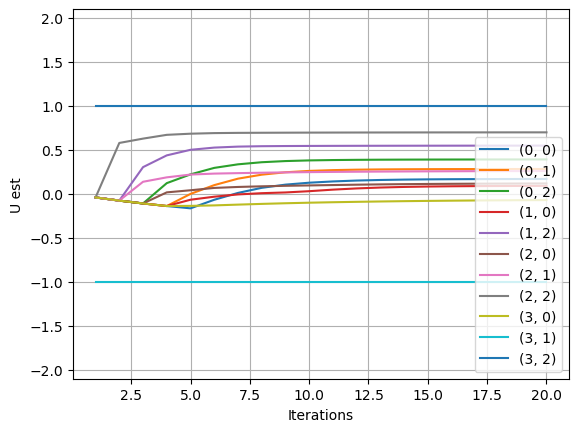

In [24]:
graph_utility_estimates(U_iterations, grid_world_4x3 , 20, [(0,0),(0,1),(0,2),(1,0),(1,2),(2,0),(2,1),(2,2),(3,0),(3,1),(3,2)])  

- CHECKPOINT: We note that the algorithm has converged to a solution within 15 iterations in this case.

<div style="border:2px solid red"></div>

----

###### Q6.3.3b [**OPTIONAL**]: Widgets  <font color=red> (you can skip this step if your pywidgets installation is not working!)</font>

Next, we define a function to create the visualisation from the utilities returned by **value_iteration_instru**. The reader need not concern herself/himself with the code that immediately follows as it is the usage of Matplotib with IPython Widgets. If you are interested in reading more about these visit [ipywidgets.readthedocs.io](http://ipywidgets.readthedocs.io)

In [25]:
def make_plot_grid_step_function(columns, row, U_over_time):
    '''ipywidgets interactive function supports
       single parameter as input. This function
       creates and return such a function by taking
       in input other parameters
    '''
    def plot_grid_step(iteration):
        data = U_over_time[iteration]
        data = defaultdict(lambda: 0, data)
        grid = []
        for row in range(rows):
            current_row = []
            for column in range(columns):
                current_row.append(data[(column, row)])
            grid.append(current_row)
        grid.reverse() # output like book
        fig = plt.imshow(grid, cmap=plt.cm.bwr, interpolation='nearest')

        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

        for col in range(len(grid)):
            for row in range(len(grid[0])):
                magic = grid[col][row]
                fig.axes.text(row, col, "{0:.2f}".format(magic), va='center', ha='center')

        plt.show()
    
    return plot_grid_step

def make_visualize(slider):
    ''' Takes an input a slider and returns 
        callback function for timer and animation
    '''
    
    def visualize_callback(Visualize, time_step):
        if Visualize is True:
            for i in range(slider.min, slider.max + 1):
                slider.value = i
                time.sleep(float(time_step))
    
    return visualize_callback
    

In [26]:
columns = 4
rows = 3
plot_grid_step = make_plot_grid_step_function(columns, rows, U_iterations)

Now, run the follwing code and you should see the values of the utilities in each iteration (depending on your widget installation you may also see some sliders):

In [27]:
iteration_slider = widgets.IntSlider(min=1, max=25, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = True)
#time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0.5'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)

display(a)

interactive(children=(IntSlider(value=1, description='iteration', max=25, min=1), Output()), _dom_classes=('wi…

interactive(children=(ToggleButton(value=True, description='Visualize'), ToggleButtons(description='Extra Dela…

- <font color=dark-magent>TASK:</FONT>Inspect the plot above to observe how the utility changes across iterations. If (and only if) your widgets installation is correct, it is also possible to move the slider using arrow keys or to jump to the value by directly editing the number with a double click. The **Visualize Button** will automatically animate the slider for you. 

----

##### Q6.3.4 Finding the policy: Maximum Expected Utility

With the estimated utility for each state, we can now determine the best policy by selecting the action with the maximum expected utility.

Let us first define the required functions by running the follwing code:

In [28]:
def expected_utility(a, s, U, mdp):
    "The expected utility of doing a in state s, according to the MDP and U."
    return sum([p * U[s1] for (p, s1) in mdp.T(s, a)])

In [29]:
def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action. (Equation 17.4)"""
    pi = {}
    for s in mdp.states:
        pi[s] = argmax(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi

- Now, let's find the recommend policy by calling the relevant functions

In [30]:
U_est = value_iteration(grid_world_4x3, 0.00001) # rerun solver
pi_opt = best_policy(grid_world_4x3, U_est)
pi_opt

{(0, 1): (0, 1),
 (1, 2): (1, 0),
 (2, 1): (-1, 0),
 (0, 0): (0, 1),
 (3, 1): None,
 (2, 0): (0, 1),
 (3, 0): (0, -1),
 (0, 2): (1, 0),
 (2, 2): (1, 0),
 (1, 0): (-1, 0),
 (3, 2): None}

We can visualize the solution in terms of recommended actions in each state:

In [31]:
print_table(grid_world_4x3.to_arrows(pi_opt))

>   >      >   .
^   None   <   .
^   <      ^   v


* <font color=dark-magent>TASK:</font>Examine the solution and discuss if/how this makes sense in terms of the transitions model and rewards (hint: start by explaning why the agent policy suggests that we should go left in state (1,0) (note: the python grid maze is zero-indexed) )

<div style="border:2px solid red">
<font color="red">SOLUTION</font>

It makes sense given that the cost of making a step in the world (-0.04) is low compared to the potential gain (+1), e.g. in (1,0) we go left (i.e. a detour) to avoid the potentially negative reward in (3,1). This will change depending on the rewards and transition model (see Q6.4).

</div>

---

#### Q6.4 Changing the MDP: State-space, transition models, reward structure and discounting

<font color=dark-magent>KEY TASK:</font>
We suggest that you experiment with value-iteration and policy finding methods to understand how the policy change has a result of different models, parameters settings. To do this we suggest that you iterate the following steps:

Modify the transition model, rerun the solver and inspect the policy for the following cases (i.e. rerun the code in Q6.4.1):
* a) Modify the transition mode so Pr is now 0.1 and Pl is 0.2; does that change the policy ?
* b) Set the transition model to be very sure or very insecure about outcome of actions (e.g. 98% sure of making the intended action)
* c) Set the discount factor to 0.001 ($\approx 0$) (what does this mean?)
* d) Change the size of the rewards (set e.g. Rstep to -2 and observe that the agent simply wants to leave the environment as soon as possible) 
 

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

Let's first define a version of the Grid world that allows us to easily change the transition model:

In [32]:
class GridMDPV2(MDP):

    """A two-dimensional grid MDP, as in [Figure 17.1].  All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state).  Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9,Pa=0.7,Pl=.1, Pr=0.2):
        grid.reverse()  # because we want row 0 on bottom, not on top
        MDP.__init__(self, init, actlist=orientations,
                     terminals=terminals, gamma=gamma)
        self.grid = grid
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.Pa = Pa
        self.Pl = Pl
        self.Pr = Pr
        for x in range(self.cols):
            for y in range(self.rows):
                self.reward[x, y] = grid[y][x]
                if grid[y][x] is not None:
                    self.states.add((x, y))

    def T(self, state, action):
        if action is None:
            return [(0.0, state)]
        else:
            return [(self.Pa, self.go(state, action)),
                    (self.Pr, self.go(state, turn_right(action))),
                    (self.Pl, self.go(state, turn_left(action)))]

    def go(self, state, direction):
        "Return the state that results from going in this direction."
        state1 = vector_add(state, direction)
        return state1 if state1 in self.states else state

    def to_grid(self, mapping):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""
        return list(reversed([[mapping.get((x, y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {
            (1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})

<font color=Red>Q6.4a: Modify the transition mode so Pright is now 0.1 and Pleft is 0.2; does that change the policy ?</font>

In [33]:
Rstep = -0.04  # the reward for being in a non-terminal state
Rt    = 1      # defines the reward for ending in a terminal state
gamma = 0.9 # discounting factor

grid_world_4x3_a = GridMDPV2([[Rstep, Rstep, Rstep, Rt],
                          [Rstep, None,  Rstep, -Rt],
                          [Rstep, Rstep, Rstep, Rstep]],
                          terminals=[(3, 2), (3, 1)],
                          init=[(0, 0)],
                          gamma=gamma,
                          #Pa=0.7,Pl=.1, Pr=0.2  #this is the orginal transition model
                          Pa=0.7,Pl=.2, Pr=0.1  
                          )
print("")
print("Policy:")
U_est_a = value_iteration(grid_world_4x3_a, 0.00001) # rerun solver
print(U_est_a)

pi_opt_a = best_policy(grid_world_4x3_a, U_est_a)
print_table(grid_world_4x3_a.to_arrows(pi_opt_a))


Policy:
{(0, 1): 0.33750442056754393, (1, 2): 0.6069380874085165, (2, 1): 0.43056683408866203, (0, 0): 0.22980546137290622, (3, 1): -1.0, (2, 0): 0.26708227146879165, (3, 0): 0.0466601660350543, (0, 2): 0.45456874074936526, (2, 2): 0.7667695304611012, (1, 0): 0.17570024507918186, (3, 2): 1.0}
>   >      >   .
^   None   ^   .
^   >      ^   <


- CHECKPOINT: You should see that the action in (1,0) has changed because intuatively there is now little chance (albeit) not zero chance of ending up in the the bad state (-1 reward) if in (2,1). 

<font color=Red>Q6.4b: Set the transition model to be very sure or very insecure about the outcome of actions (e.g. 98% sure of making the intended action)</font>

In [34]:
Rstep = -0.04  # the reward for being in a non-terminal state
Rt    = 1      # defines the reward for ending in a terminal state
gamma = 0.9 # discounting factor

grid_world_4x3_b = GridMDPV2([[Rstep, Rstep, Rstep, Rt],
                          [Rstep, None,  Rstep, -Rt],
                          [Rstep, Rstep, Rstep, Rstep]],
                          terminals=[(3, 2), (3, 1)],
                          init=[(0, 0)],
                          gamma=gamma,
                          #Pa=0.7,Pl=.1, Pr=0.2  #this is the orginal transition model
                          #Pa=0.99,Pl=.005, Pr=.005  
                          Pa=1,Pl=0.0, Pr=0.0  
                          )
U_est_b = value_iteration(grid_world_4x3_b, 0.00001) # rerun solver
pi_opt_b = best_policy(grid_world_4x3_b, U_est_b)

print("Utilities:")
print(U_est_b)
print("")
print("Policy:")
print_table(grid_world_4x3_b.to_arrows(pi_opt_b))

Utilities:
{(0, 1): 0.5185399999999999, (1, 2): 0.734, (2, 1): 0.734, (0, 0): 0.42668599999999995, (3, 1): -1.0, (2, 0): 0.6205999999999999, (3, 0): 0.5185399999999999, (0, 2): 0.6205999999999999, (2, 2): 0.86, (1, 0): 0.5185399999999999, (3, 2): 1.0}

Policy:
>   >      >   .
^   None   ^   .
>   >      ^   <


- CHECKPOINT: Being very sure does not change the policy from Q6.4b allthough notice that the utilities are different (i.e. the policy can be the same eventhough the utilities are different!)

<font color=red>... let's try out a very insecure agent:</font>

In [35]:
Rstep = -0.04  # the reward for being in a non-terminal state
Rt    = 1      # defines the reward for ending in a terminal state
gamma = 0.9 # discounting factor

grid_world_4x3_bb = GridMDPV2([[Rstep, Rstep, Rstep, Rt],
                          [Rstep, None,  Rstep, -Rt],
                          [Rstep, Rstep, Rstep, Rstep]],
                          terminals=[(3, 2), (3, 1)],
                          init=[(0, 0)],
                          gamma=gamma,
                          #Pa=0.7,Pl=.1, Pr=0.2  #this is the orginal transition model
                          #Pa=0.99,Pl=.005, Pr=.005  
                          Pa=1.0/3.0,Pl=1.0/3.0, Pr=1.0/3.0  
                          )
U_est_bb = value_iteration(grid_world_4x3_bb, 0.00001) # rerun solver
pi_opt_bb = best_policy(grid_world_4x3_bb, U_est_bb)

print("Utilities:")
print(U_est_bb)
print("")
print("Policy:")
print_table(grid_world_4x3_bb.to_arrows(pi_opt_bb))

Utilities:
{(0, 1): -0.026974662435346936, (1, 2): 0.2631575210871137, (2, 1): 0.12377251267673803, (0, 0): -0.12023184591961888, (3, 1): -1.0, (2, 0): -0.06207309124242295, (3, 0): -0.14655721711678696, (0, 2): 0.0973678164747648, (2, 2): 0.4842102953875574, (1, 0): -0.1352743754198828, (3, 2): 1.0}

Policy:
^   >      ^   .
^   None   <   .
<   v      <   v


- CHECKPOINT: Now we want to avoid the -1 reward state because there is a high risk of ending up there if we get near it. In (2,3) we even suggest to move up rather than try to go directly for (3,2) because there is equal chance of ending up in (1,3),(2,3),(3,2) and up but the up action is not associated with any chance of going down (and ending up in the -1 state). 

<font color=Red>Q6.4c) Set the discount factor to 0 (what does this mean?)</font>

In [36]:
Rstep = -0.04  # the reward for being in a non-terminal state
Rt    = 1      # defines the reward for ending in a terminal state
gamma_c = 0.001 # discounting factor

grid_world_4x3_c = GridMDPV2([[Rstep, Rstep, Rstep, Rt],
                          [Rstep, None,  Rstep, -Rt],
                          [Rstep, Rstep, Rstep, Rstep]],
                          terminals=[(3, 2), (3, 1)],
                          init=[(0, 0)],
                          gamma=gamma_c,
                          Pa=0.7,Pl=.1, Pr=0.2  #this is the orginal transition model                    
                          )
U_est_c = value_iteration(grid_world_4x3_c, 0.00001, verbose=True) # rerun solver

print("Utilities:")
print(U_est_c)
print("")
print("Policy:")

pi_opt_c = best_policy(grid_world_4x3_c, U_est_c)
print_table(grid_world_4x3_c.to_arrows(pi_opt_c))

epsilon=1e-05
epsilon * (1 - gamma) / gamma=0.00999

delta =1.0
delta =0.0006880000000000011
Utilities:
{(0, 1): -0.04, (1, 2): -0.04, (2, 1): -0.04, (0, 0): -0.04, (3, 1): -1.0, (2, 0): -0.04, (3, 0): -0.04, (0, 2): -0.04, (2, 2): -0.04, (1, 0): -0.04, (3, 2): 1.0}

Policy:
>   >      >   .
>   None   <   .
>   >      >   v


- CHECKPOINT: Setting $\gamma$ very close to zero means that we favor immediate rewards over future (potential) reward. You should see that the utilities convege to roughly the rewards for the individual state beause $G_t\approx R(S)$ not involving any future rewards (as is always the case for the temrinal states). Setting $\gamma=0$ will often lead to non-convergence or even divide by zero issues).

<font color=Red>Q6.4d) Change the size of the rewards (set e.g. Rstep to -2 and observe that the agent simply wants to leave the environment as soon as possible) </font>

In [37]:
Rstep_d = -2 # the reward for being in a non-terminal state
Rt    = 1    # defines the reward for ending in a terminal state
gamma = 0.9  # discounting factor

grid_world_4x3_d = GridMDPV2([[Rstep_d, Rstep_d, Rstep_d, Rt],
                          [Rstep_d, None,  Rstep_d, -Rt],
                          [Rstep_d, Rstep_d, Rstep_d, Rstep_d]],
                          terminals=[(3, 2), (3, 1)],
                          init=[(0, 0)],
                          gamma=gamma,
                          Pa=0.7,Pl=.1, Pr=0.2  #this is the orginal transition model                         
                          )
U_est_d = value_iteration(grid_world_4x3_d, 0.00001, verbose=False) # rerun solver
pi_opt_d = best_policy(grid_world_4x3_d, U_est_d)

print("Utilities:")
print(U_est_d)
print("")
print("Policy:")
print_table(grid_world_4x3_d.to_arrows(pi_opt_d))

Utilities:
{(0, 1): -8.978228465961493, (1, 2): -4.701706046161707, (2, 1): -3.8822162985649324, (0, 0): -9.388321176804716, (3, 1): -1.0, (2, 0): -5.8200545084699815, (3, 0): -3.84610354281084, (0, 2): -7.228742369861085, (2, 2): -2.273405421203089, (1, 0): -7.762512785331908, (3, 2): 1.0}

Policy:
>   >      >   .
^   None   >   .
>   >      >   ^


- CHECKPOINT: The agent now want to leave i.e. aims directly for a terminal state regardless of the reward recieved at the terminal state. The cost of walking around is simply to great for the agent to do detours. It even suggest going right in state (0,0). Getting out asap is the rational choice in this case !

<div style="border:2px solid red"></div>

----

#### Q6.5 Policy Iteration [**OPTIONAL**]

<font color=dark-magent>TASK:</font> Solve the GridMDP problem above using the Policy Iteration method and compare the solution with Value Iteration (you should find the same solution)

<font color=dark-magent>TASK:</font> Measure and compare the rate of convergence by plotting the convergence of the utiltities.


* Hint: The functions below implement the policy iteration solver from AIMA.

In [38]:
def policy_iteration(mdp):
    "Solve an MDP by policy iteration [Figure 17.7]"
    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = argmax(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return pi

In [39]:
def policy_evaluation(pi, U, mdp, k=20):
    """Return an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum([p * U[s1] for (p, s1) in T(s, pi[s])])
    return U

---